### **LSI Topic Modeling**
### Scrape .pdf files
We only need to do this one time to download the files into the folder you're working in.

In [114]:
import os
import re

import pandas as pd
import pdfplumber
import requests
import gensim
import nltk

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from collections import namedtuple
from bs4 import BeautifulSoup as bs
from gensim.models import CoherenceModel

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
DOMAIN = "https://papers.xtremepape.rs/"
URL = "https://papers.xtremepape.rs/index.php?dirpath=./CAIE/IGCSE/Geography+%280460%29/&order=1"
FILETYPE = ".pdf"

output_folder = "pdf_files"
os.makedirs(output_folder, exist_ok=True)

def get_soup(url):
    return bs(requests.get(url).text, 'html.parser')

for link in get_soup(URL).find_all('a'):
    file_link = link.get('href')
    if file_link.startswith('CAIE/IGCSE') and FILETYPE in file_link and "_qp_2" in file_link:
        print(file_link)
        try:
            file_path = os.path.join(output_folder, link.text)
            with open(link.text, 'wb') as file:
                response = requests.get(DOMAIN + file_link)
                file.write(response.content)
        except Exception as e:
            print("Error downloading file:", e)
            continue


CAIE/IGCSE/Geography (0460)/0460_w21_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w21_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w21_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_21.pdf
CAIE/IGCSE/Ge

### Import Data
> *Start running from the cell below if you've already imported the files previously.*

In [115]:
Line = namedtuple('Line', 'Paper_ID Question_ID Question_Type Question_Text Token_Text Word_Count')
# file = '0460_w21_qp_22.pdf'

### Pre-processing

In [224]:
total_check = 0
skip_lines = True
concatenate = True
questionNo = 1

concatenated_lines = []

data = []

ignore_patterns = [
    r'^\d+\s*[A-Z]+\s*\d+/\d+/\d+',  # Lines with exam details
    r'^\d+\s*(BLANK PAGE|TURN OVER|Additional Pages)',  # Lines indicating blank pages or page turns
    r'^\[Total:\s*\d+\]$',  # Lines starting with total marks
    r'^© UCLES \d+\s*$',  # Lines starting with copyright information
    r'^\.{3,}',  # Lines starting with three or more dots
    r'\.{10,}', # Lines that contain three or more dots
    r'cid', # Lines that contain 'cid'
    r'© UCLES', # Lines that contain '© UCLES'
    r'^\d+( \d+)*$' # Lines that contain digits and spaces
]

current_dir = os.getcwd()
output_folder = "pdf_files"
pdf_folder_path = os.path.join(current_dir, output_folder)

files = [f for f in os.listdir(pdf_folder_path) if f.endswith('.pdf')]

for file in files:
    print(file)
    lines = []
    file_path = os.path.join(pdf_folder_path, file)
    with pdfplumber.open(file_path) as pdf:
        Paper_ID = file
        for page in pdf.pages:
            text = page.extract_text()
            for line in text.split('\n'):

                if any(re.search(pattern, line) for pattern in ignore_patterns):
                    # print(line)
                    continue
                elif len(line.strip()) <= 5:
                    continue
                elif 'Additional Pages' in line:
                    skip_lines = True
                    continue
                elif line.startswith('*') and line.endswith('*'):
                    skip_lines = False
                    continue
                elif skip_lines:
                    continue
                else:
                    lines.append(line.strip())

    concatenated_line = ''

    for line in lines:
        if line.startswith('(') == False and not re.search(r'^\d(\d\s| )', line):
            concatenated_line = concatenated_line + line + ' '
        else:
            if concatenated_line != "":
                concatenated_lines.append(concatenated_line.strip())
                
                if concatenated_line.startswith('('):
                    Question_Type = 'SUB'
                    Question_ID = re.search(r'^\((.*?)\)', concatenated_line).group(0)
                elif re.search(r'^\d(\d\s| )', concatenated_line):
                    Question_Type = 'MAIN'
                    Question_ID = re.search(r'^\d(\d\s| )', concatenated_line).group(0)
                    # Question_Text = re.search(r'^\((.*?)\)', line).group(2)

                Question_Text = concatenated_line.replace(str(Question_ID), "")
                Token_Question_Text = word_tokenize(Question_Text)
                tags = pos_tag(Token_Question_Text)
                filtered_words = [word for word, pos in tags
                  if (len(word) > 1) and
                     (not re.match(r'^\d+\.\d$', word)) and
                     (not word.isnumeric()) and
                     (word.lower() not in stopwords.words('english')) and
                     (word.lower() != 'fig') and
                     (word.lower() != 'km') and
                     (word.lower() != 'km2') and
                     (word.lower() != 'figs')]
                # filtered_nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNS') and (len(word) > 1) and word.lower() not in stopwords.words('english')]
                # Token_Text = ' '.join(filtered_nouns)
                Token_Text = ' '.join(filtered_words)
                Word_Count = len(Question_Text)
                data.append(Line(Paper_ID, Question_ID, Question_Type, Question_Text, Token_Text, Word_Count))
                # print(concatenated_line)
            concatenated_line = line + ' '
        
print(concatenated_lines)


0460_m17_qp_22.pdf
0460_m18_qp_22.pdf
0460_m19_qp_22.pdf
0460_m20_qp_22.pdf
0460_m21_qp_22.pdf
0460_m22_qp_22.pdf
0460_s14_qp_21.pdf
0460_s14_qp_22.pdf
0460_s14_qp_23.pdf
0460_s15_qp_21.pdf
0460_s15_qp_22.pdf
0460_s15_qp_23.pdf
0460_s16_qp_21.pdf
0460_s16_qp_22.pdf
0460_s16_qp_23.pdf
0460_s18_qp_21.pdf
0460_s18_qp_22.pdf
0460_s18_qp_23.pdf
0460_s19_qp_21.pdf
0460_s19_qp_22.pdf
0460_s19_qp_23.pdf
0460_s20_qp_21.pdf
0460_s20_qp_22.pdf
0460_s20_qp_23.pdf
0460_s21_qp_21.pdf
0460_s21_qp_22.pdf
0460_s21_qp_23.pdf
0460_s22_qp_21.pdf
0460_s22_qp_22.pdf
0460_s22_qp_23.pdf
0460_w14_qp_21.pdf
0460_w14_qp_22.pdf
0460_w14_qp_23.pdf
0460_w15_qp_21.pdf
0460_w15_qp_22.pdf
0460_w15_qp_23.pdf
0460_w16_qp_21.pdf
0460_w16_qp_22.pdf
0460_w16_qp_23.pdf
0460_w17_qp_21.pdf
0460_w17_qp_22.pdf
0460_w17_qp_23.pdf
0460_w18_qp_21.pdf
0460_w18_qp_22.pdf
0460_w18_qp_23.pdf
0460_w19_qp_21.pdf
0460_w19_qp_22.pdf
0460_w19_qp_23.pdf
0460_w20_qp_21.pdf
0460_w20_qp_22.pdf
0460_w20_qp_23.pdf
0460_w21_qp_21.pdf
0460_w21_qp_

### Basic Visualization

In [225]:
df = pd.DataFrame(data)
df.head(50)

,Paper_ID,Question_ID,Question_Type,Question_Text,Token_Text,Word_Count
0,0460_m17_qp_22.pdf,1,MAIN,"Study the map extract for Ballyvaghan, Ireland...",Study map extract Ballyvaghan Ireland scale 1:50,71
1,0460_m17_qp_22.pdf,(a),SUB,The map has blue grid lines which make square...,map blue grid lines make squares area land one...,126
2,0460_m17_qp_22.pdf,10,MAIN,km2,,4
3,0460_m17_qp_22.pdf,20,MAIN,km2,,4
4,0460_m17_qp_22.pdf,50,MAIN,km2 100 km2,,12
5,0460_m17_qp_22.pdf,(b),SUB,(i) Height above sea level is shown by contou...,Height sea level shown contour lines differenc...,159
6,0460_m17_qp_22.pdf,(ii),SUB,What does the green shading in grid square 28...,green shading grid square show,55
7,0460_m17_qp_22.pdf,(c),SUB,Fig. 1 shows some of the features in the east...,shows features east map extract Study map extr...,140
8,0460_m17_qp_22.pdf,(i),SUB,Identify feature A.,Identify feature,21
9,0460_m17_qp_22.pdf,(ii),SUB,Identify the type of road at B.,Identify type road,33


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Paper_ID       2704 non-null   object
 1   Question_ID    2704 non-null   object
 2   Question_Type  2704 non-null   object
 3   Question_Text  2704 non-null   object
 4   Token_Text     2704 non-null   object
 5   Word_Count     2704 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 126.9+ KB


In [227]:
res = df.Token_Text.str.split(expand=True).stack().value_counts()
print(res.head(30))

map            447
shows          433
shown          413
extract        338
population     313
Using          305
area           282
one            259
answer         248
Table          234
two            230
Study          221
Describe       217
river          215
Tick           213
features       189
information    176
settlement     159
road           159
feature        158
following      154
areas          148
Insert         146
south          143
north          139
use            138
metres         137
Total          126
height         124
marks          123
Name: count, dtype: int64


In [228]:
res2 = df.Token_Text.str.split(expand=True).stack()
print(res2)

0     0           Study
      1             map
      2         extract
      3     Ballyvaghan
      4         Ireland
               ...     
2703  6        Identify
      7             one
      8           cause
      9      extinction
      10        species
Length: 28987, dtype: object


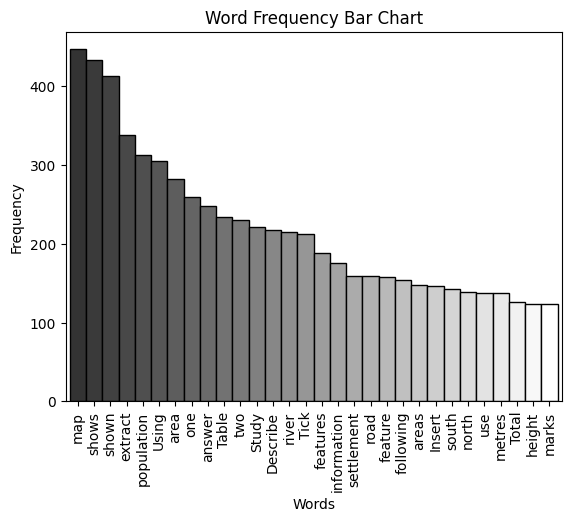

In [229]:
import matplotlib.pyplot as plt
import numpy as np

res.iloc[0:30].plot(kind='bar', color=plt.cm.gray(np.linspace(0.2, 1, 30)), edgecolor='black', width=1)

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart')

plt.show()

In [230]:
# df.to_csv('scrape.csv', index=True)
print(data)
print(df['Token_Text'].str.split().tolist())

[Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='1 ', Question_Type='MAIN', Question_Text='Study the map extract for Ballyvaghan, Ireland. The scale is 1:50 000. ', Token_Text='Study map extract Ballyvaghan Ireland scale 1:50', Word_Count=71), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='(a)', Question_Type='SUB', Question_Text=' The map has blue grid lines which make squares. What area of land does one grid square show? Tick one answer below. Tick (3) ', Token_Text='map blue grid lines make squares area land one grid square show Tick one answer Tick', Word_Count=126), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='10 ', Question_Type='MAIN', Question_Text='km2 ', Token_Text='', Word_Count=4), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='20 ', Question_Type='MAIN', Question_Text='km2 ', Token_Text='', Word_Count=4), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='50 ', Question_Type='MAIN', Question_Text='km2 100 km2 ', Token_Text='', Word_Count=12), Line(Paper_ID='0460_m17

### Bi-gram Phrase Model

In [231]:
word_list = df['Token_Text'].str.split().tolist()
word_list = [sublist for sublist in word_list if sublist]
print(word_list[0])
print(word_list)
bigram = gensim.models.Phrases(word_list, min_count=20, threshold=10) # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[word_list[0]])
# set1 = set(word_list[0])
# set2 = set(bigram_model[word_list[0]])
# diff_in_list1 = set1 - set2
# print(diff_in_list1)

['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50']
[['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50'], ['map', 'blue', 'grid', 'lines', 'make', 'squares', 'area', 'land', 'one', 'grid', 'square', 'show', 'Tick', 'one', 'answer', 'Tick'], ['Height', 'sea', 'level', 'shown', 'contour', 'lines', 'difference', 'height', 'contour', 'lines', 'map', 'Tick', 'one', 'answer', 'Tick'], ['green', 'shading', 'grid', 'square', 'show'], ['shows', 'features', 'east', 'map', 'extract', 'Study', 'map', 'extract', 'answer', 'questions'], ['Identify', 'feature'], ['Identify', 'type', 'road'], ['Give', 'six-figure', 'grid', 'reference', 'road', 'junction'], ['Give', 'height', 'sea', 'level', 'spot', 'height'], ['Describe', 'gradient', 'road'], ['shows', 'location', 'coastal', 'settlements', 'Ballyvaghan', 'Bealaclugga', 'BBeeaallaacclluuggggaa', 'BBaallllyyvvaagghhaann'], ['person', 'travels', 'along', 'N67', 'road', 'main', 'road', 'junction', 'Ballyvaghan', 'road

In [232]:
norm_corpus_bigrams = [bigram_model[q] for q in word_list]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Total Vocabulary Size:', len(dictionary))
print('Sample word to number mappings:', list(dictionary.items())[:30])
dictionary.filter_extremes(no_below=9)
print('Total Vocabulary Size:', len(dictionary))
print('Probed sample word to number mappings:', list(dictionary.items())[:30])

Total Vocabulary Size: 4193
Sample word to number mappings: [(0, 'Ballyvaghan'), (1, 'Ireland'), (2, 'Study_map'), (3, 'extract'), (4, 'scale_1:50'), (5, 'Tick'), (6, 'Tick_one'), (7, 'answer'), (8, 'area'), (9, 'blue'), (10, 'grid'), (11, 'land'), (12, 'lines'), (13, 'make'), (14, 'map'), (15, 'one'), (16, 'show'), (17, 'square'), (18, 'squares'), (19, 'Height'), (20, 'contour'), (21, 'difference'), (22, 'height'), (23, 'sea_level'), (24, 'shown'), (25, 'green'), (26, 'shading'), (27, 'answer_questions'), (28, 'east'), (29, 'features')]
Total Vocabulary Size: 602
Probed sample word to number mappings: [(0, 'Ireland'), (1, 'Study_map'), (2, 'extract'), (3, 'scale_1:50'), (4, 'Tick'), (5, 'Tick_one'), (6, 'answer'), (7, 'area'), (8, 'blue'), (9, 'grid'), (10, 'land'), (11, 'map'), (12, 'one'), (13, 'show'), (14, 'square'), (15, 'squares'), (16, 'contour'), (17, 'difference'), (18, 'height'), (19, 'sea_level'), (20, 'shown'), (21, 'answer_questions'), (22, 'east'), (23, 'features'), (24,

In [233]:
word_list_by_paper = df.groupby('Paper_ID')['Token_Text'].apply(lambda x: ' '.join(x)).str.split().tolist()
print(word_list[0])
print(word_list)
bigram = gensim.models.Phrases(word_list, min_count=20, threshold=10)
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[word_list[0]])

['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50']
[['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50'], ['map', 'blue', 'grid', 'lines', 'make', 'squares', 'area', 'land', 'one', 'grid', 'square', 'show', 'Tick', 'one', 'answer', 'Tick'], ['Height', 'sea', 'level', 'shown', 'contour', 'lines', 'difference', 'height', 'contour', 'lines', 'map', 'Tick', 'one', 'answer', 'Tick'], ['green', 'shading', 'grid', 'square', 'show'], ['shows', 'features', 'east', 'map', 'extract', 'Study', 'map', 'extract', 'answer', 'questions'], ['Identify', 'feature'], ['Identify', 'type', 'road'], ['Give', 'six-figure', 'grid', 'reference', 'road', 'junction'], ['Give', 'height', 'sea', 'level', 'spot', 'height'], ['Describe', 'gradient', 'road'], ['shows', 'location', 'coastal', 'settlements', 'Ballyvaghan', 'Bealaclugga', 'BBeeaallaacclluuggggaa', 'BBaallllyyvvaagghhaann'], ['person', 'travels', 'along', 'N67', 'road', 'main', 'road', 'junction', 'Ballyvaghan', 'road

In [234]:
norm_corpus_bigrams = [bigram_model[p] for p in word_list]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Total Vocabulary Size:', len(dictionary))
print('Sample word to number mappings:', list(dictionary.items())[:30])
dictionary.filter_extremes(no_below=9)
print('Total Vocabulary Size:', len(dictionary))
print('Probed sample word to number mappings:', list(dictionary.items())[:30])

Total Vocabulary Size: 4193
Sample word to number mappings: [(0, 'Ballyvaghan'), (1, 'Ireland'), (2, 'Study_map'), (3, 'extract'), (4, 'scale_1:50'), (5, 'Tick'), (6, 'Tick_one'), (7, 'answer'), (8, 'area'), (9, 'blue'), (10, 'grid'), (11, 'land'), (12, 'lines'), (13, 'make'), (14, 'map'), (15, 'one'), (16, 'show'), (17, 'square'), (18, 'squares'), (19, 'Height'), (20, 'contour'), (21, 'difference'), (22, 'height'), (23, 'sea_level'), (24, 'shown'), (25, 'green'), (26, 'shading'), (27, 'answer_questions'), (28, 'east'), (29, 'features')]
Total Vocabulary Size: 602
Probed sample word to number mappings: [(0, 'Ireland'), (1, 'Study_map'), (2, 'extract'), (3, 'scale_1:50'), (4, 'Tick'), (5, 'Tick_one'), (6, 'answer'), (7, 'area'), (8, 'blue'), (9, 'grid'), (10, 'land'), (11, 'map'), (12, 'one'), (13, 'show'), (14, 'square'), (15, 'squares'), (16, 'contour'), (17, 'difference'), (18, 'height'), (19, 'sea_level'), (20, 'shown'), (21, 'answer_questions'), (22, 'east'), (23, 'features'), (24,

### Latent Semantic Indexing (LSI)

In [235]:
corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print([(dictionary[idx] , freq) for idx, freq in corpus[1][:50]])
print('Total number of questions:', len(corpus))

[('Tick', 1), ('Tick_one', 1), ('answer', 1), ('area', 1), ('blue', 1), ('grid', 2), ('land', 1), ('map', 1), ('one', 1), ('show', 1), ('square', 1), ('squares', 1)]
Total number of questions: 2665


In [236]:
TOPIC_NO = 30
lsi_bow = gensim.models.LsiModel(corpus, id2word=dictionary, num_topics=TOPIC_NO, onepass=True, chunksize=2655, power_iters=1000)

for topic_id, topic in lsi_bow.print_topics(num_topics=30, num_words=3):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.299*"number" + 0.262*"use" + 0.251*"Insert"

Topic #2:
-0.393*"shows" + -0.284*"area" + -0.279*"areas"

Topic #3:
-0.543*"population" + 0.487*"river" + -0.356*"Table"

Topic #4:
-0.619*"river" + -0.334*"population" + 0.299*"features"

Topic #5:
-0.441*"areas" + 0.416*"river" + 0.356*"shown"

Topic #6:
0.463*"population" + -0.408*"area" + -0.390*"Table"

Topic #7:
0.604*"Table" + -0.424*"area" + -0.313*"population"

Topic #8:
0.570*"shows" + -0.424*"shown" + 0.268*"area"

Topic #9:
-0.474*"plate" + 0.437*"area" + -0.331*"shown"

Topic #10:
0.298*"Tick" + 0.294*"settlement" + 0.278*"plate"

Topic #11:
0.365*"settlement" + 0.232*"Table" + -0.219*"Tick"

Topic #12:
0.604*"settlement" + -0.290*"area" + 0.267*"shows"

Topic #13:
-0.510*"water" + 0.298*"Tick" + -0.227*"Using"

Topic #14:
-0.494*"per" + 0.267*"two" + -0.263*"people"

Topic #15:
-0.417*"water" + 0.378*"Using" + -0.336*"road"

Topic #16:
0.387*"two" + 0.259*"Describe" + 0.259*"road"

Topic #17:
0.294*"water" + 0.254*

### Interpretation
Different directions of each topic means different angles of the topic, similar to branches.
> **e.g.** *Topic #4: The topic is rivers, areas, and measurements. It could further discuss roads and electricity.*

In [237]:
# for n in range(TOPIC_NO):
#     print('Topic #'+str(n+1)+':')
#     print('='*50)
#     d1 = []
#     d2 = []
#     for term, wt in lsi_bow.show_topic(n, topn=20):
#         if wt >= 0:
#             d1.append((term, round(wt, 3)))
#         else:
#             d2.append((term, round(wt, 3)))

#     print('Direction 1:', d1)
#     print('-'*50)
#     print('Direction 2:', d2)
#     print('-'*50)
#     print()

for n in range(TOPIC_NO):
    print('Topic', n)

    d1 = []
    d2 = []

    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    if d1:
        print('Direction 1:', ' '.join([f'{term}' for term, wt in d1]))
    else:
        print('Direction 1:')


    if d2:
        print('Direction 2:', ' '.join([f'{term}' for term, wt in d2]))
    else:
        print('Direction 2:')

    print()


Topic 0
Direction 1: number use Insert question answer paper Write end diagrams Question_Paper Survey_Map Extract pages Question shown questions part provided pen enclosed
Direction 2:

Topic 1
Direction 1:
Direction 2: shows area areas map_extract shown two features river population table Using Table answer_questions Study one Tick extract settlement Describe land

Topic 2
Direction 1: river areas map_extract two table Tick features boxes
Direction 2: population Table shows per countries rate South total age percentage country people

Topic 3
Direction 1: features map_extract shown extract Study_map Using identify_following answer_questions shows
Direction 2: river population Tick Table water per countries two people metres four

Topic 4
Direction 1: river shown features Table extract Using map_extract Study_map identify_following Describe
Direction 2: areas two area table Area tick Complete one land putting

Topic 5
Direction 1: population features map_extract extract Study_map answe

### Latent Dirichlet Allocation (LDA)

In [238]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=600,
                                            passes=50,
                                            alpha='auto',
                                            per_word_topics=True)


In [239]:
get_lda_topics(lda_model, 10)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10
0,population,river,Tick_one,number,features,feature,population,Describe,Table,water
1,Table,cross_section,type,high,map_extract,South,road,shown,area,Using_information
2,per,shown,Tick,question,shows,Identify,extract,two,Using,Using
3,countries,Table,temperature,largest,areas,distribution,level,area,earthquake,year
4,country,Tick,box,use,two,Africa,years,shows,land_use,shown
5,rate,Look,station,end,shown,migration,Study_map,Total_marks,industry,line
6,people,settlement,shown,low,answer_questions,world,answer,Insert,relief,use
7,one,River,mm,power,plate,State,total,evidence,development,cross-section
8,percentage,height,weather,international_boundary,Using,growth,change,settlement,shows,complete
9,information,metres_metres,rainfall,Insert,extract,shows,edge_map,Suggest,main,show


In [240]:
text = df['Token_Text'].str.split()

text = text.apply(lambda x: ' '.join(x)).tolist()
textlist = [sentence.split() for sentence in text]

print(textlist)

[['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50'], ['map', 'blue', 'grid', 'lines', 'make', 'squares', 'area', 'land', 'one', 'grid', 'square', 'show', 'Tick', 'one', 'answer', 'Tick'], [], [], [], ['Height', 'sea', 'level', 'shown', 'contour', 'lines', 'difference', 'height', 'contour', 'lines', 'map', 'Tick', 'one', 'answer', 'Tick'], ['green', 'shading', 'grid', 'square', 'show'], ['shows', 'features', 'east', 'map', 'extract', 'Study', 'map', 'extract', 'answer', 'questions'], ['Identify', 'feature'], ['Identify', 'type', 'road'], ['Give', 'six-figure', 'grid', 'reference', 'road', 'junction'], ['Give', 'height', 'sea', 'level', 'spot', 'height'], ['Describe', 'gradient', 'road'], ['shows', 'location', 'coastal', 'settlements', 'Ballyvaghan', 'Bealaclugga', 'BBeeaallaacclluuggggaa', 'BBaallllyyvvaagghhaann'], ['person', 'travels', 'along', 'N67', 'road', 'main', 'road', 'junction', 'Ballyvaghan', 'road', 'junction', 'Bealaclugga', 'far', 'person', 'travel', 'G

In [244]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
print(cm.get_coherence())
cm = CoherenceModel(model=lda_model, texts=textlist, coherence='c_v')
print(cm.get_coherence())


-10.165632421281286
nan


c:\Python311\Lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


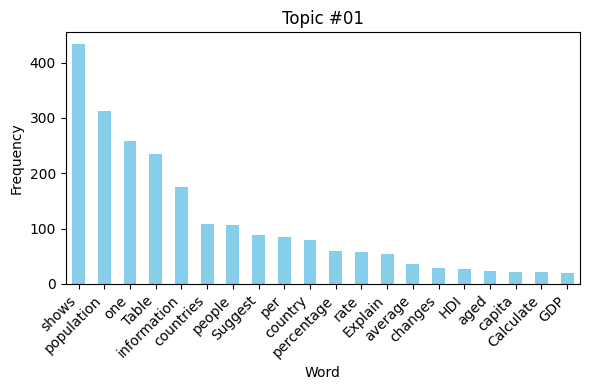

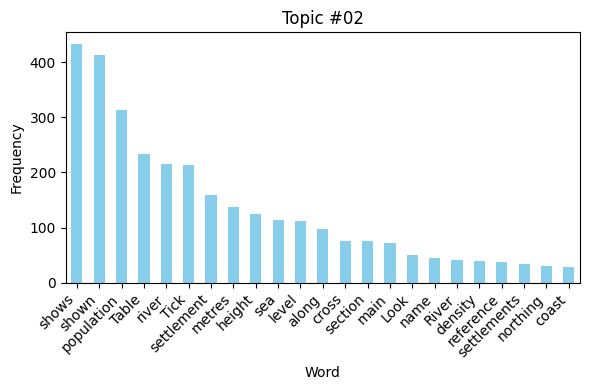

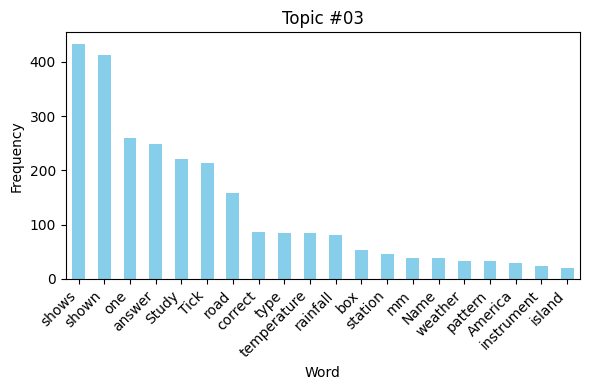

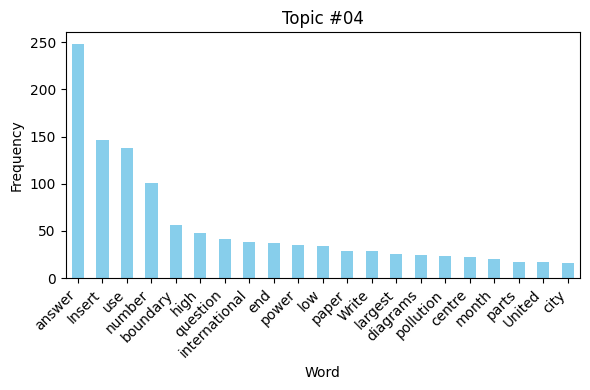

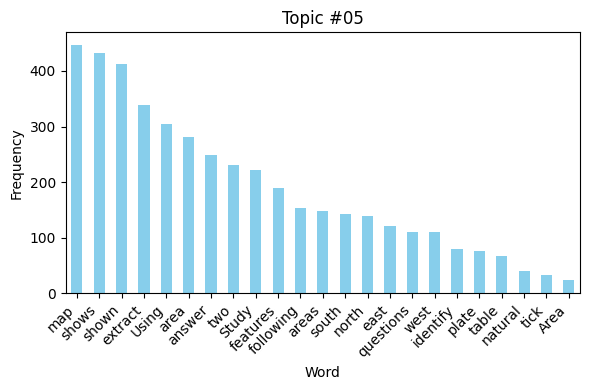

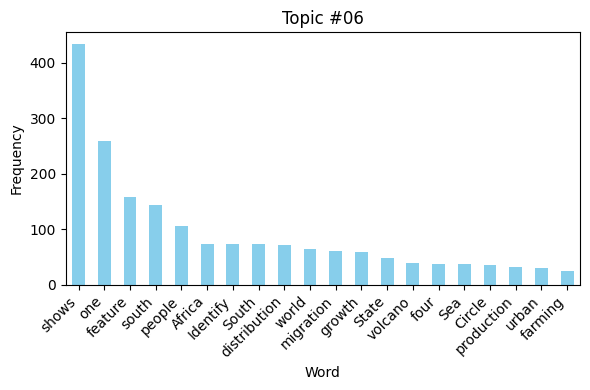

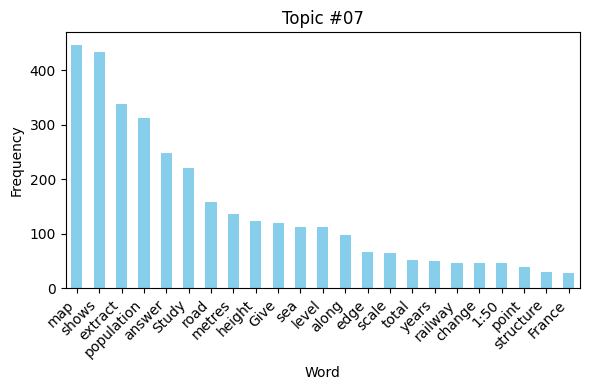

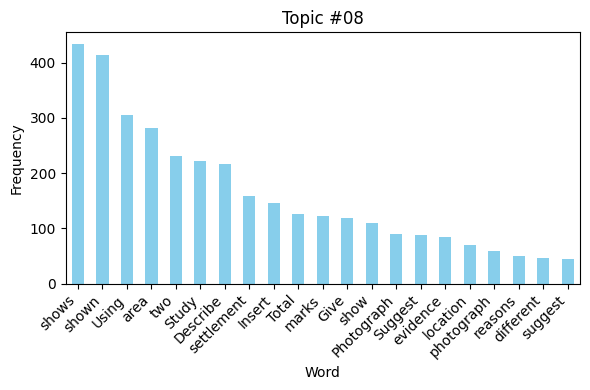

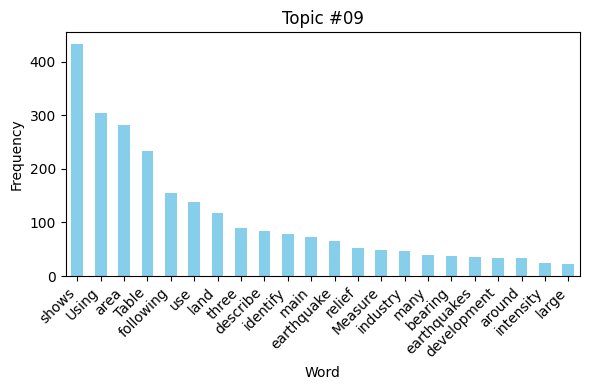

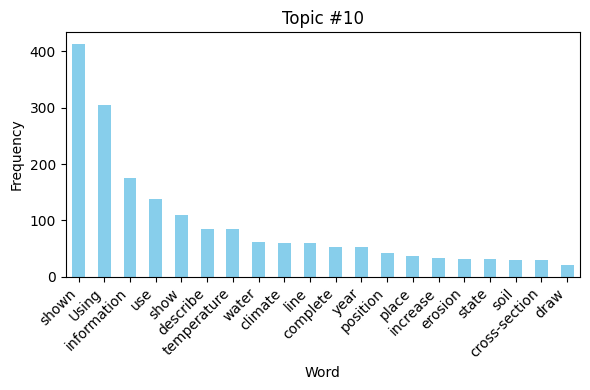

In [242]:
def plot_bar_charts(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn=20)
        word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]

    for topic, words in word_dict.items():
        plt.figure(figsize=(6, 4))
        ax = plt.subplot(111)
        split_words = []
        for word in words:
            if '_' in word:
                split_words.extend(word.split('_'))
            else:
                split_words.append(word)
        word_freq = df.Token_Text.str.split(expand=True).stack().value_counts()
        freqs = word_freq[word_freq.index.isin(split_words)]
        freqs.sort_values(ascending=False).plot(kind='bar', color='skyblue', ax=ax)
        plt.title(topic)
        plt.xlabel('Word')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
# plot_word_clouds(lda_model,10)

plot_bar_charts(lda_model,10)
